**Summary**

In this code we will implement the TinyML to detect the driver drowsiness

# PreProcessing phase


#### Import Packages

The following packages will be used to implement a basic system in Python. Importing libraries and layers from tensorflow.

In [ ]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
import logging
logging.getLogger("tensorflow").setLevel(logging.DEBUG)

import tensorflow as tf
assert float(tf.__version__[:3]) >= 2.3

DEBUG:tensorflow:Falling back to TensorFlow client; we recommended you install the Cloud TPU client directly with pip install cloud-tpu-client.


In [ ]:
import os
import zipfile
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
import cv2
import dlib
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

#### Mounts Google drive with Google CoLab to import dataset.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

zip_ref = zipfile.ZipFile("/content/drive/My Drive/Driver_Drowsiness_Dataset.zip", 'r')
zip_ref.extractall("/tmp")
zip_ref.close()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
os.chdir("/content/drive/My Drive/driver_drowsiness_dataset/train")

In [ ]:
labels = os.listdir("../train")
labels

['eyes',
 '.ipynb_checkpoints',
 'drowiness_new20.model',
 'models_code1_mask',
 'exp_saved_model',
 'model-optimization',
 'DL_Model_Saved',
 'tflite_qaware_model.tflite',
 'model_tl.tflite',
 'DL_Models_Saved_MobileNet-V3',
 'tf_lite_model.tflite',
 'tf_model_fashion_mnist',
 'tmp',
 'drowiness_new6.model',
 'tf_model_fashion_mnist.h5',
 'drowiness_new20.h5',
 'models1',
 'AlexNetModel_1.hdf5',
 'DL_model_Saved',
 'models',
 'Closed_1',
 'AlexNetModel.hdf5',
 'Open',
 'Open_1',
 'yawn (1)',
 'no_yawn',
 'Closed',
 'tf_model_h5.h5',
 'drowiness_new6.h5',
 'OpenFace_1',
 'ClosedFace_1',
 'yawn',
 'no_yawn_1',
 'yawn_1',
 'ClosedFace',
 'OpenFace']

In [ ]:
a = plt.imread("/content/drive/My Drive/driver_drowsiness_dataset/train/yawn/Driver_0_9981.jpeg")
a.shape

(480, 640, 3)

In [ ]:
prototxtPath= os.path.join ("/content/drive/My Drive/files/deploy.prototxt.txt")
caffemodelPath =  os.path.join ("/content/drive/My Drive/files/res10_300x300_ssd_iter_140000.caffemodel")

detector = cv2.dnn.readNet(prototxtPath, caffemodelPath)

In [ ]:
dlib_shape_predictor= os.path.join ("/content/drive/My Drive/files/shape_predictor_68_face_landmarks.dat")

face_detector = dlib.get_frontal_face_detector()
#landmark_detector = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
landmark_detector = dlib.shape_predictor(dlib_shape_predictor)


Import and processing Yawn and No-Yawn categories






In [ ]:
def face_for_yawn_No_yawn(direc="/content/drive/My Drive/driver_drowsiness_dataset/train", face_cas_path="drive/My Drive/driver_drowsiness_dataset/prediction/haarcascade_frontalface_default.xml"):
    yawn_no_yawn_data = []
    IMG_SIZE = 192
    categories = ["yawn", "no_yawn"]
    for category in categories:
        path_link = os.path.join(direc, category)
        category_num = categories.index(category)
        print("category of yawn_no_yawn in dataset", category_num)
        for image in os.listdir(path_link):
            image_array = cv2.imread(os.path.join(path_link, image), cv2.IMREAD_COLOR)
            faces = face_detector(image_array, 1)
            for (i, rect) in enumerate(faces):
              x = rect.left()
              y = rect.top()
              w = rect.right() - x
              h = rect.bottom() - y

              img = cv2.rectangle(image_array, (x, y), (x+w, y+h), (0, 255, 0), 2)
              resized_array = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

              yawn_no_yawn_data.append([resized_array, category_num])
    print ("len of yawn_no_yawn_data", len(yawn_no_yawn_data))
    return yawn_no_yawn_data


yawn_no_yawn = face_for_yawn_No_yawn()


# using three method
# 1-Haar = 475
# 2- hog detector = 1131
# 3- dlip = 1131
# 4- ssd = 1412


category of yawn_no_yawn in dataset 0
category of yawn_no_yawn in dataset 1
len of yawn_no_yawn_data 2135


#### Processing dataset

Import and processing Close and Open eyes categories

If the Driver Open him/her Eyes the State is not Droswy, else Closed him/her eyes the State is Drowsy. 

In [ ]:
def face_for_eyes(dir_path="/content/drive/My Drive/driver_drowsiness_dataset/train", face_cas="drive/My Drive/driver_drowsiness_dataset/prediction/haarcascade_frontalface_default.xml", eye_cas="drive/My Drive/driver_drowsiness_dataset/prediction/haarcascade_eye.xml"):
    labels = ['ClosedFace_1', 'OpenFace_1']
    IMG_SIZE = 192
    eyes_data = []
    for label in labels:
        path = os.path.join(dir_path, label)
        category_num = labels.index(label)
        category_num +=2
        print("category of closed_open_eyes in dataset ",category_num)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                eyes_data.append([resized_array, category_num])
            except Exception as e:
                print(e)
    print ("len", len(eyes_data))
    return eyes_data

Colsed_Open_eyes = face_for_eyes()

category of closed_open_eyes in dataset  2
category of closed_open_eyes in dataset  3
len 4317


Append all categories of dataset to append_data function

In [ ]:
def append_data():
#     total_data = []
    yawn_no_yawn = face_for_yawn_No_yawn()
    eyes_data = face_for_eyes()
    yawn_no_yawn.extend(eyes_data)
    return np.array(yawn_no_yawn)

new_data = append_data()

category of yawn_no_yawn in dataset 0
category of yawn_no_yawn in dataset 1
len of yawn_no_yawn_data 2135
category of closed_open_eyes in dataset  2
category of closed_open_eyes in dataset  3
len 4317


<ipython-input-12-0985ec8657d2>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(yawn_no_yawn)


Assign all features of dataset to **X** and Labels to **y**

In [ ]:
X = []
y = []
for feature, label in new_data:
    X.append(feature)
    y.append(label)


In [ ]:
X = np.array(X)
print ("X shape", X.shape)
X = X.reshape(-1, 192, 192, 3)
print (X.shape)
print (len(X))

X shape (6452, 192, 192, 3)
(6452, 192, 192, 3)
6452


Import LabelBinarizer class with transform method to convert multi-class labels to binary labels.

In [ ]:
from sklearn.preprocessing import LabelBinarizer
label_bin = LabelBinarizer()
y = label_bin.fit_transform(y)
print (y.shape)

(6452, 4)


**Name of Label in dataset with Codes:**
*   ywan = 1000
*   No_yawn = 0100
*   Close Eyes = 0010
*   Open Eyes = 0001


In [ ]:
y = np.array(y)
print(len(y))

6452


#### Split dataset 

Use **train_test_split** to splitting dataset to 70# for training and 30% for testing dataset

In [ ]:
from sklearn.model_selection import train_test_split
test_size = 0.30
seed=40
train_images, test_images, train_labels, test_labels = train_test_split(X, y, random_state=seed, test_size=test_size)
print ("train images",len(train_images))
print ("test_images ",len(test_images))

train images 4516
test_images  1936


#### Data Augmentation for Training dataset

Import ImageDataGenerator to generate training dataset with (rescale=1/255, zoom_range=0.2, horizontal_flip=True, rotation_range=30)

In [ ]:
# ImageDataGenerator rotation
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1/255, zoom_range=0.2, horizontal_flip=True, rotation_range=30)
train_generator = datagen.flow(train_images, train_labels,shuffle=True, batch_size=32) # غيرت الباتش سايز)

print ("train images generator",len(train_generator))

train images generator 142


#### Scalar Testing dataset

 Using StandardScalar class with MinMaxScaler function to scaling the Test dataset. As a resulte the range of data was **from 0.07 to 0.99**

**Note**: we are not used the StandardScalar with scaler function, because the range of data was (-2.06 , 3.01). As a resulte was 0.60% of accuracy and the loss was 1.25
```
scaler = preprocessing.StandardScaler()
X_test_scalar= scaler.fit_transform(test_images.reshape(-1, X_test.shape[-1])).reshape(test_images.shape)
print ("the scalar is",X_test_scalar)
```


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

test_images = np.array(test_images)

min_max_scaler = preprocessing.MinMaxScaler()
test_images_minmax = min_max_scaler.fit_transform(test_images.reshape(-1, test_images.shape[-1])).reshape(test_images.shape)
print ("", len(test_images_minmax))
#print ("the scalar is",test_images_minmax)
#Range of min_max from (0.07 to 0.99)

 1936


#### Sample of Training dataset

[0 0 0 1]


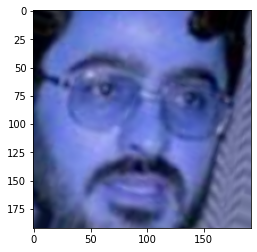

[0 0 0 1]


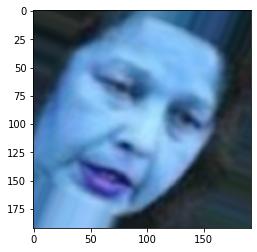

[0 0 0 1]


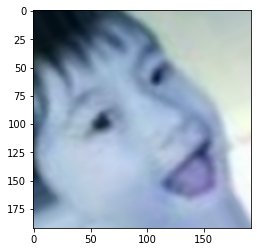

[0 0 1 0]


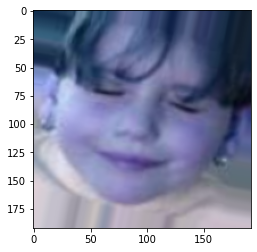

[0 0 0 1]


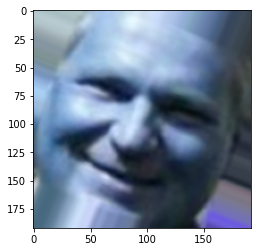

[1 0 0 0]


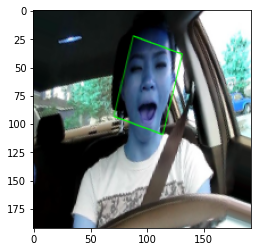

[0 0 0 1]


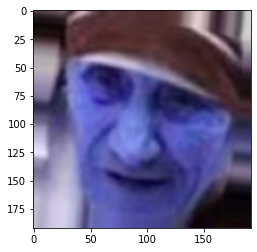

[0 0 1 0]


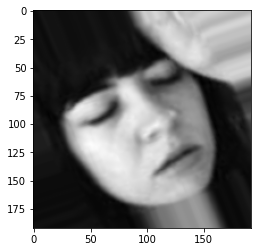

[0 0 0 1]


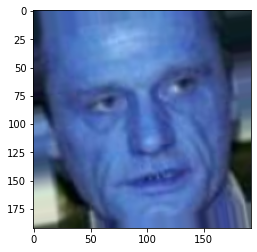

In [ ]:
train_images1,train_labels1 = train_generator.next()
for i in range(0,9):
    image = train_images1[i]
    label = train_labels1[i]
    print (label)
    plt.imshow(image, cmap=plt.get_cmap('gray'))
    plt.show()

# Training model Phase

In [ ]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential

In [ ]:
import tensorflow.keras
from tensorflow.keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten,\
 Conv2D, MaxPooling2D,BatchNormalization

# Initializing the CNN
model = Sequential()

# Convolution Step 1
model.add(Convolution2D(32, 11, strides = (4, 4), padding = 'valid', input_shape=(192,192,3)))
model.add(BatchNormalization())
model.add(Activation ('relu'))
# Max Pooling Step 1
model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'valid'))
#model.add(Dropout(0.1))

# Convolution Step 2
model.add(Convolution2D(64, 11, strides = (1, 1), padding='valid'))
model.add(BatchNormalization())
model.add(Activation ('relu'))
# Max Pooling Step 2
model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding='valid'))
#model.add(Dropout(0.1))

# Convolution Step 3
model.add(Convolution2D(128, 3, strides = (1, 1), padding='valid'))
model.add(BatchNormalization())
model.add(Activation ('relu'))

# Max Pooling Step 3
model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'valid'))
#model.add(BatchNormalization())


# Flattening Step
model.add(Flatten())

# Full Connection Step
model.add(Dense(units = 512, activation = 'relu'))
model.add(Dropout(0.4))
#model.add(Dense(units = 4096, activation = 'relu'))
#model.add(Dropout(0.4))

model.add(Dense(units = 4, activation = 'softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        11648     
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 46, 46, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        247872    
                                                                 
 batch_normalization_1 (Batc  (None, 13, 13, 64)       2

In [ ]:
optimizer1 = tf.keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=True,
    name='Adam',
)
model.compile(loss="categorical_crossentropy",
              optimizer= optimizer1,
              metrics=["accuracy"])

import time

start = time.time()
#model.fit() # Training statement
history = model.fit(train_generator, epochs=200,  shuffle=True,validation_data= (test_images_minmax, test_labels),validation_steps=len(test_images_minmax))

print("Total time: ", time.time() - start, "seconds")


Epoch 1/200
142/142 [==============================] - 44s 301ms/step - loss: 0.7236 - accuracy: 0.6592 - val_loss: 3.3980 - val_accuracy: 0.3388
Epoch 2/200
142/142 [==============================] - 42s 299ms/step - loss: 0.5860 - accuracy: 0.7146 - val_loss: 1.3269 - val_accuracy: 0.5522
Epoch 3/200
142/142 [==============================] - 43s 300ms/step - loss: 0.5178 - accuracy: 0.7538 - val_loss: 0.9632 - val_accuracy: 0.5279
Epoch 4/200
142/142 [==============================] - 43s 301ms/step - loss: 0.4529 - accuracy: 0.7910 - val_loss: 1.3162 - val_accuracy: 0.4551
Epoch 5/200
142/142 [==============================] - 42s 299ms/step - loss: 0.4352 - accuracy: 0.8009 - val_loss: 1.2096 - val_accuracy: 0.5098
Epoch 6/200
142/142 [==============================] - 43s 300ms/step - loss: 0.3875 - accuracy: 0.8246 - val_loss: 1.2001 - val_accuracy: 0.5434
Epoch 7/200
142/142 [==============================] - 42s 298ms/step - loss: 0.3690 - accuracy: 0.8364 - val_loss: 0.5451 -

In [ ]:
from keras import layers
for i, layer in enumerate(model.layers):
   print(i, layer.name)

model.summary()

0 conv2d
1 batch_normalization
2 activation
3 max_pooling2d
4 conv2d_1
5 batch_normalization_1
6 activation_1
7 max_pooling2d_1
8 conv2d_2
9 batch_normalization_2
10 activation_2
11 max_pooling2d_2
12 flatten
13 dense
14 dropout
15 dense_1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        11648     
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 46, 46, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 32)       0         
 )                                                               
              

#### Evaluation a model using Test dataset 

In [ ]:
test_loss, test_accuracy = model.evaluate(test_images_minmax, test_labels, verbose=1)
print('Test accuracy :', test_accuracy)
print('Test loss :', test_loss)

print('model accuracy is %.2f%% and Loss accuracy is %.2f%%' % (test_accuracy, test_loss))

61/61 [==============================] - 1s 14ms/step - loss: 0.0573 - accuracy: 0.9881
Test accuracy : 0.9881198406219482
Test loss : 0.05733496695756912
model accuracy is 0.99% and Loss accuracy is 0.06%


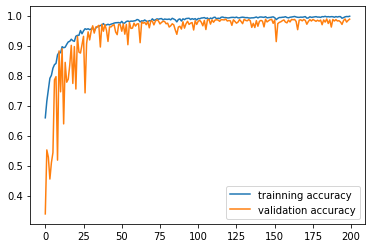

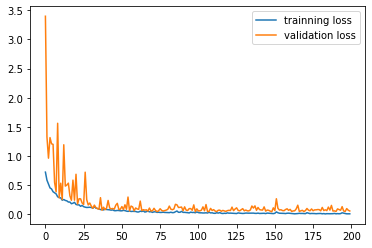

In [ ]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(train_accuracy))

plt.plot(epochs, train_accuracy, label="trainning accuracy")
plt.plot(epochs, val_accuracy, label="validation accuracy")

plt.legend()
plt.show()

plt.plot(epochs, train_loss, label="trainning loss")
plt.plot(epochs, val_loss, label="validation loss")
plt.legend()
plt.show()

In [ ]:
prediction_model= model.predict(test_images_minmax, verbose=1)

prediction_classes_model = np.argmax(prediction_model, axis=1)
test_labels_prediction= np.argmax(test_labels, axis=1)


61/61 [==============================] - 1s 13ms/step


In [ ]:
labels_classes = ['yawn', 'no_yawn', 'Closed', 'Open']

The result of the model using precision, recall and f1-score

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(test_labels_prediction, prediction_classes_model, target_names=labels_classes))

              precision    recall  f1-score   support

        yawn       0.98      0.99      0.98       272
     no_yawn       0.99      0.98      0.99       353
      Closed       0.98      1.00      0.99       620
        Open       1.00      0.98      0.99       691

    accuracy                           0.99      1936
   macro avg       0.99      0.99      0.99      1936
weighted avg       0.99      0.99      0.99      1936



Plot the confusion_matrix

Confusion matrix, without normalization


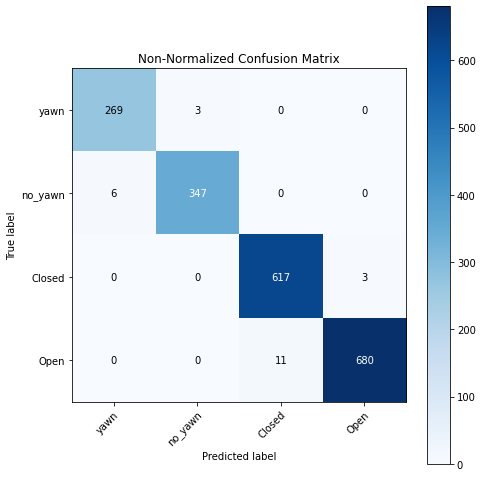

In [ ]:
from sklearn.metrics import confusion_matrix


#Defining function for confusion matrix plot
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(test_labels_prediction, prediction_classes_model)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    fig, ax = plt.subplots(figsize=(7,7))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

np.set_printoptions(precision=2)

#Plotting the confusion matrix
confusion_mtx=confusion_matrix(test_labels_prediction, prediction_classes_model)

# Plotting non-normalized confusion matrix
plot_confusion_matrix(test_labels_prediction, prediction_classes_model, classes=labels_classes,
                      title='Non-Normalized Confusion Matrix')

Normalized confusion matrix


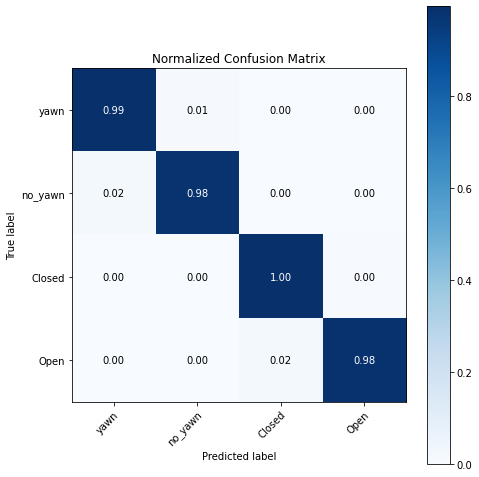

In [ ]:
# Plotting normalized confusion matrix
plot_confusion_matrix (test_labels_prediction, prediction_classes_model, classes= labels_classes, normalize=True, title='Normalized Confusion Matrix')

# Define paths to model files


In [ ]:
MODELS_DIR = 'DL_Model_Saved/'
if not os.path.exists(MODELS_DIR):
    os.mkdir(MODELS_DIR)
MODEL_TF = MODELS_DIR + 'model'
MODEL_TF2 = MODELS_DIR + 'model2.h5'
MODEL_NO_QUANT_TFLITE = MODELS_DIR + 'model_no_quant.tflite'
MODEL_QAWARE= MODELS_DIR + 'tflite_qaware_model.tflite'
MODEL_TFLITE = MODELS_DIR + 'model_tflite.tflite'
MODEL_TFLITE_PTQF = MODELS_DIR + 'model_tflite_PTQF.tflite'
MODEL_TFLITE_MICRO = MODELS_DIR + 'model_tflite_micro.cc'

# models Size

*get_file_size* function to know the size for all the models files

convert it to Megabytes, Kilobytes and bytes.

In [ ]:
#code for know the size of model from youtube
def get_file_size(file_path):
    size = os.path.getsize(file_path)
    return size

def convert_bytes(size, unit=None):
    if unit == "KB":
        return print('File size: ' + str(round(size / 1024, 3)) + ' Kilobytes')
    elif unit == "MB":
        return print('File size: ' + str(round(size / (1024 * 1024), 3)) + ' Megabytes')
    else:
        return print('File size: ' + str(size) + ' bytes')

convert_bytes(get_file_size(MODEL_TF), "MB")

File size: 0.004 Megabytes


In [ ]:
# Calculate size
size_tf = os.path.getsize(MODEL_TF)
size_tf2 = os.path.getsize(MODEL_TF2)
size_no_quant_tflite = os.path.getsize(MODEL_NO_QUANT_TFLITE)
size_PTQ = os.path.getsize(MODEL_TFLITE)
size_qaware = os.path.getsize(MODEL_QAWARE)
size_PTQF = os.path.getsize(MODEL_TFLITE_PTQF)


print ("size tf", size_tf)
print ("size tf", size_tf2)
print ("size tf", size_no_quant_tflite)
print ("size tf", size_qaware)
print ("size tf", size_PTQ)
print ("size tf", size_PTQF)


convert_bytes(get_file_size(MODEL_TF), "MB")
convert_bytes(get_file_size(MODEL_TF2), "MB")
convert_bytes(get_file_size(MODEL_NO_QUANT_TFLITE), "MB")
convert_bytes(get_file_size(MODEL_QAWARE), "MB")
convert_bytes(get_file_size(MODEL_TFLITE), "MB")
convert_bytes(get_file_size(MODEL_TFLITE_PTQF), "MB")


#3

# Compare size
pd.DataFrame.from_records(
    [["TensorFlow", f"{size_tf} bytes", ""],
     ["TensorFlow", f"{size_tf2} bytes", ""],
     ["TensorFlow Lite", f"{size_no_quant_tflite} bytes ", f"(reduced by {size_tf - size_no_quant_tflite} bytes)"],
    ["TensorFlow  Lite Quantized", f"{size_qaware} bytes", f"(reduced by {size_no_quant_tflite - size_qaware} bytes)"]],columns = ["Model", "Size", ""], index="Model")

size tf 4096
size tf 2141160
size tf 483380
size tf 151408
size tf 147408
size tf 149488
File size: 0.004 Megabytes
File size: 2.042 Megabytes
File size: 0.461 Megabytes
File size: 0.144 Megabytes
File size: 0.141 Megabytes
File size: 0.143 Megabytes


,Size,
Model,,
TensorFlow,4096 bytes,
TensorFlow,2141160 bytes,
TensorFlow Lite,483380 bytes,(reduced by -479284 bytes)
TensorFlow Lite Quantized,151408 bytes,(reduced by 331972 bytes)


# Save model

In [ ]:
model.save(MODEL_TF)

INFO:tensorflow:Assets written to: DL_Model_Saved/model/assets


In [ ]:
model.save(MODEL_TF2)

In [ ]:
#Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_TF)
model_no_quant_tflite = converter.convert()

# Save the model to disk
open(MODEL_NO_QUANT_TFLITE, "wb").write(model_no_quant_tflite)

2396864

# **Quantization-Aware-Training**

In [ ]:
! pip install -q tensorflow-model-optimization
import tensorflow_model_optimization as tfmot


     |████████████████████████████████| 238 kB 4.9 MB/s 


In [ ]:
#الي ضابط
import tensorflow_model_optimization as tfmot

# Create a base model
base_model = model

# `quantize_apply` actually makes the model quantization aware.
q_aware_model = tfmot.quantization.keras.quantize_model(model)

q_aware_model.compile(loss="categorical_crossentropy",
              optimizer= optimizer1,
              metrics=["accuracy"])

q_aware_model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quantize_layer (QuantizeLay  (None, 192, 192, 3)      3         
 er)                                                             
                                                                 
 quant_conv2d (QuantizeWrapp  (None, 46, 46, 32)       11713     
 erV2)                                                           
                                                                 
 quant_batch_normalization (  (None, 46, 46, 32)       129       
 QuantizeWrapperV2)                                              
                                                                 
 quant_activation (QuantizeW  (None, 46, 46, 32)       3         
 rapperV2)                                                       
                                                                 
 quant_max_pooling2d (Quanti  (None, 23, 23, 32)       1

In [ ]:

optimizer1 = tf.keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=True,
    name='Adam',
)
q_aware_model.compile(loss="categorical_crossentropy",
              optimizer= optimizer1,
              metrics=["accuracy"])



In [ ]:
q_aware_model.fit(train_generator, epochs=30,  shuffle=True, validation_data= (test_images_minmax, test_labels), validation_steps=len(test_images_minmax))

Epoch 1/30
142/142 [==============================] - 49s 338ms/step - loss: 0.0473 - accuracy: 0.9854 - val_loss: 0.1982 - val_accuracy: 0.9509
Epoch 2/30
142/142 [==============================] - 48s 338ms/step - loss: 0.0364 - accuracy: 0.9885 - val_loss: 0.1550 - val_accuracy: 0.9597
Epoch 3/30
142/142 [==============================] - 47s 329ms/step - loss: 0.0445 - accuracy: 0.9867 - val_loss: 0.1002 - val_accuracy: 0.9726
Epoch 4/30
142/142 [==============================] - 47s 328ms/step - loss: 0.0601 - accuracy: 0.9812 - val_loss: 0.2960 - val_accuracy: 0.9158
Epoch 5/30
142/142 [==============================] - 46s 326ms/step - loss: 0.0491 - accuracy: 0.9803 - val_loss: 0.1304 - val_accuracy: 0.9700
Epoch 6/30
142/142 [==============================] - 47s 327ms/step - loss: 0.0335 - accuracy: 0.9885 - val_loss: 0.1221 - val_accuracy: 0.9659
Epoch 7/30
142/142 [==============================] - 46s 326ms/step - loss: 0.0352 - accuracy: 0.9878 - val_loss: 0.3572 - val_ac

In [ ]:
q_aware_model.evaluate(test_images_minmax, test_labels)

61/61 [==============================] - 2s 19ms/step - loss: 0.0845 - accuracy: 0.9778


[0.08446000516414642, 0.9777892827987671]

# **Convert and Optimize model phase**

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_qaware_model = converter.convert()

# Save the model to disk
open(MODEL_QAWARE, "wb").write(tflite_qaware_model)
#quantize_model_len= len(tflite_qaware_model) /1024
#print ('QAT len is',quantize_model_len)
    
#with open("tflite_qaware_model.tflite", 'wb') as f:
 #   f.write(tflite_qaware_model)

INFO:tensorflow:Assets written to: /tmp/tmptj0bvydq/assets
/usr/local/lib/python3.8/dist-packages/tensorflow/lite/python/convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


611968

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_TF)

converter.optimizations = [tf.lite.Optimize.DEFAULT]

model_tflite = converter.convert()

# Save the model to disk
open(MODEL_TFLITE, "wb").write(model_tflite)
#quantize_model_len= len(tflite_qaware_model) /1024
#print ('QAT len is',quantize_model_len)
    
#with open("tflite_qaware_model.tflite", 'wb') as f:
 #   f.write(tflite_qaware_model)

607712

# Running model using Interpreter phase


Running inferences model using the TensorFlow Lite [`Interpreter`](https://www.tensorflow.org/api_docs/python/tf/lite/Interpreter) for all images to compare the model accuracies between models

In [ ]:
import numpy as np
#test_labels = np.array(test_images_minmax , axis=0)

def evaluate_model(interpreter):
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  # Run predictions on every image in the "test" dataset.
  prediction_digits = []
  for i, test_image in enumerate(test_images_minmax):
    #if i % 1000 == 0:
     # print('Evaluated on {n} results so far.'.format(n=i))
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
    interpreter.set_tensor(input_index, test_image)

    #Time
    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    output = interpreter.tensor(output_index)
    digit = np.argmax(output()[0])
    prediction_digits.append(digit)

  print('\n')
  # Compare prediction results with ground truth labels to calculate accuracy.
  prediction_digits = np.array(prediction_digits)
  accuracy = (prediction_digits == test_labels_prediction).mean()
  
  return accuracy

In [ ]:
#Interpreter QAT
interpreter = tf.lite.Interpreter(model_content=tflite_qaware_model)
interpreter.allocate_tensors()
start1=time.time()
test_accuracy = evaluate_model(interpreter)
print("total time", time.time()-start1, "second")


print('Quant test_accuracy:', test_accuracy)




total time 8.240842342376709 second
Quant test_accuracy: 0.9777892561983471


In [ ]:
#interpreter PTQ
interpreter = tf.lite.Interpreter(model_path=MODEL_TFLITE)
interpreter.allocate_tensors()
start = time.time()

test_accuracy = evaluate_model(interpreter)
print("Total time: ", time.time() - start, "seconds")
print('Quant TFLite test_accuracy:', test_accuracy)




Total time:  8.211721658706665 seconds
Quant TFLite test_accuracy: 0.9886363636363636


#Full Integer Quantization 

In [ ]:
test_images_minmax = np.array(test_images_minmax, dtype=np.float32)
def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(test_images_minmax).batch(1).take(100):
    yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]

converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

model_tflite_PTQF = converter.convert()

# Save the Quantize model
open(MODEL_TFLITE_PTQF, "wb").write(model_tflite_PTQF)

INFO:tensorflow:Assets written to: /tmp/tmpszbn46rz/assets
/usr/local/lib/python3.8/dist-packages/tensorflow/lite/python/convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


611240

Running Interpreter 
for Full Integer Quantization 

In [ ]:
def evaluate_model_PTQF(interpreter):
  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  # Run predictions on every image in the "test" dataset.
  prediction_digits = []
  predictions = np.zeros((len(test_images_minmax),), dtype=int)

  for i, test_image in enumerate(test_images_minmax):
    if input_details['dtype'] == np.uint8:
      input_scale, input_zero_point = input_details["quantization"]
      test_image = test_image / input_scale + input_zero_point


    test_image = np.expand_dims(test_image, axis=0).astype(input_details["dtype"])
    interpreter.set_tensor(input_details["index"], test_image)

    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    output = interpreter.tensor(output_details["index"])
    digit = np.argmax(output()[0])
    predictions [i]= digit
    
    print('\n')
   # Compare prediction results with ground truth labels to calculate accuracy.
  accuracy = (predictions == test_labels_prediction).mean()
  return accuracy

In [ ]:
interpreter = tf.lite.Interpreter(model_path=MODEL_TFLITE_PTQF)

start2=time.time()
interpreter.allocate_tensors()

#Evaluate Quantizaed Model using **accuracy**
test_accuracy = evaluate_model_PTQF(interpreter)
print("total time", time.time()-start2,"second")
print('Quant TFLite test_accuracy:', test_accuracy)


#Running Interpreter phase 


In [ ]:
interpreter = tf.lite.Interpreter(model_path = MODEL_TFLITE)
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("input_details", input_details)
print("output_details", output_details)

print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

interpreter.resize_tensor_input(input_details[0]['index'], (1936, 192, 192,3))
interpreter.resize_tensor_input(output_details[0]['index'], (1936, 4))
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("input_details", input_details)
print("output_details", output_details)

print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

NameError: ignored

In [ ]:
test_imgs_numpy = np.array(test_images_minmax, dtype=np.float32)

interpreter.set_tensor(input_details[0]['index'], test_imgs_numpy)
interpreter.invoke()
tflite_model_predictions = interpreter.get_tensor(output_details[0]['index'])
print("Prediction results shape:", tflite_model_predictions)
prediction_classes_tflite_model = np.argmax(tflite_model_predictions, axis=1)
print("tflite_model_predictions",prediction_classes_tflite_model)

ValueError: ignored

In [ ]:
from sklearn.metrics import accuracy_score
acc= accuracy_score(prediction_classes_tflite_model, np.argmax(test_labels, axis=1))
print("Test accuracy of TFLITE model :",acc)


####**Prediction using Quantized model and visulize the outputs**

In [ ]:
# Utilities for plotting

class_names = ["yawn", "no_yawn", "Closed", "Open"]

def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    img = np.squeeze(img)

    plt.imshow(img, cmap=plt.cm.binary)
    predicted_label = np.argmax(predictions_array)
    
    if predicted_label == true_label:
        color = 'green'
    else:
        color = 'red'
    
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                         100*np.max(predictions_array),
                                         class_names[true_label]), color=color)

In [ ]:
# Visualize the outputs { run: "auto" }
max_index = 99 #@param {type:"slider", min:0, max:99, step:1}
y_test_inter=np.argmax(test_labels, axis=1)

for index in range(0,max_index):
  plt.figure(figsize=(6,3))
  plt.subplot(1,2,1)
  plot_image(index, tflite_model_predictions, test_labels_prediction, test_imgs_numpy)
  plt.show()

# Convert model to C array phase

In [ ]:
# Install xxd if it is not available
!apt-get update && apt-get -qq install xxd
# Convert to a C source file, i.e, a TensorFlow Lite for Microcontrollers model
!xxd -i {MODEL_QAWARE} > {MODEL_TFLITE_MICRO}
# Update variable names
REPLACE_TEXT = MODEL_QAWARE.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/g_model/g' {MODEL_TFLITE_MICRO}

In [ ]:
# Print the C source file
!cat {MODEL_TFLITE_MICRO}